In [1]:
%matplotlib inline

this extension makes it easy to reload the imports without restarting the whole notebook

In [2]:
%load_ext autoreload

run this cell if you want to reload the imports (i.e. you changed notebookfns.py)

In [3]:
%autoreload

In [4]:
# these are all standard Python modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [5]:
# this is my notebookfns.py file
import notebookfns as n

In [6]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
plt.rc('lines', linewidth=3)
plt.rc('axes', linewidth=3)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)

note that these errors include the weights alpha_1, alpha_2, alpha_3
red is training error, blue is validation error


/Users/blusch/Documents/DeepKoopmanResults/notebookfns.py:10: RuntimeWarning: divide by zero encountered in log10
  errors[:, j] = np.log10(errors[:, j])
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


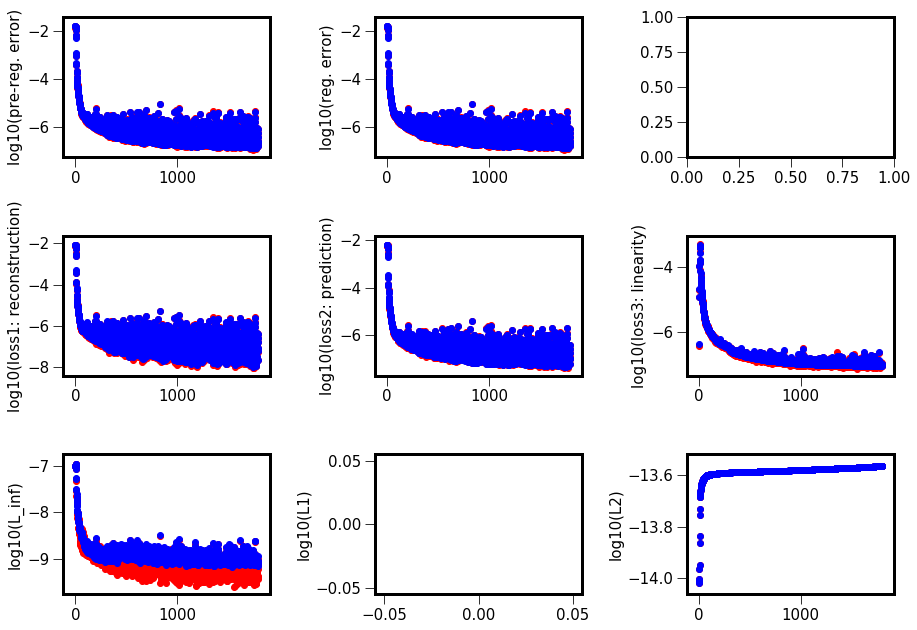

In [7]:
# You can change this filename to point to the pickle file for your model.
# Later code loads the related files (i.e. weights & biases) by changing the end of the filename
fname = './DiscreteSpectrumExample/DiscreteSpectrumExample2_2018_02_28_01_35_16_640980_model.pkl'
errors = np.loadtxt(fname.replace('model.pkl','error.csv'),delimiter=',')
n.PlotErrors(errors, range(0,16))

In [8]:
# you may need the encoding part if you save the pickle file in Python 2 and load it in Python 3 
with open(fname, 'rb') as f:
    params = pickle.load(f, encoding='latin1')

In [9]:
print('validation error: %.2E' % params['minTest'])

validation error: 1.43E-07


In [10]:
print('We had %d files of training data.' % params['data_train_len'])
print('Length of trajectories: %d steps (goes in Table 2)' % params['len_time'])
print('Batch size: %d (goes in Table 2)' % params['batch_size'])
deltat = params['delta_t']
print('delta_t (time stepping in data): %.3f' % deltat)
T = deltat*(params['len_time']-1)
tSpan = np.linspace(start=0,stop=T,num=params['len_time'],endpoint=True)
print("Time span is %r" % tSpan)

We had 1 files of training data.
Length of trajectories: 51 steps (goes in Table 2)
Batch size: 256 (goes in Table 2)
delta_t (time stepping in data): 0.020
Time span is array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])


In [11]:
print("For Table 4:")
print('log10 of alpha_1 (the weight on losses involving reconstruction): %.1f' % np.log10(params['recon_lam']))
print('log10 of alpha_2 (the weight on L_inf term): %.1f' % np.log10(params['Linf_lam']))
print('log10 of alpha_3 (the weight on L_2 regularization): %.1f' % np.log10(params['L2_lam']))

For Table 4:
log10 of alpha_1 (the weight on losses involving reconstruction): -1.0
log10 of alpha_2 (the weight on L_inf term): -7.0
log10 of alpha_3 (the weight on L_2 regularization): -15.0


In [12]:
print('The training was allowed to run up to %.1f hours' % (params['max_time']/(60*60)))
print('The training actually ran for %.1f hours' % (params['time_exp']/(60*60)))
if 'stop_condition' in params:
    print('The stop condition was: %s' % params['stop_condition'])
else:
    print('The stop condition was not labeled.')

The training was allowed to run up to 4.0 hours
The training actually ran for 2.1 hours
The stop condition was not labeled.


In [13]:
print('Did we do the autoencoder pre-training? %d' % params['auto_first'])
print('The learning rate was %.2E' % params['learning_rate'])

Did we do the autoencoder pre-training? 0
The learning rate was 1.00E-03


In [14]:
depth = (params['d']-4)/2
print("For Table 3:")
print('The encoder and decoder each had %d hidden layers.' % depth)
print('The widths of the layers of the main network were %r.' % params['widths'])
print('The aux. network had %d hidden layers.' % len(params['hidden_widths_omega']))
print('The widths of the hidden layers of the aux. network were %r.' % params['hidden_widths_omega'])

For Table 3:
The encoder and decoder each had 2 hidden layers.
The widths of the layers of the main network were [2, 30, 30, 2, 2, 30, 30, 2].
The aux. network had 3 hidden layers.
The widths of the hidden layers of the aux. network were [10, 10, 10].


In [15]:
print('We penalized %d (S_p) steps for prediction. (goes in Table 4)' % params['num_shifts'])
print('We penalized %d steps in the linearity loss.' %params['num_shifts_middle'])

We penalized 30 (S_p) steps for prediction. (goes in Table 4)
We penalized 50 steps in the linearity loss.


In [16]:
# load all of the weights and biases into W and b dictionaries
W, b = n.load_weights_koopman(fname, len(params['widths'])-1, len(params['widths_omega_real'])-1, params['num_real'], params['num_complex_pairs'])

In [17]:
# load the validation data
params['data_name'] = 'DiscreteSpectrumExample' # temp fix
X = np.loadtxt('%s_val_x.csv' % params['data_name'],delimiter=',')

In [18]:
# reshape the validation data
max_shifts_to_stack = n.num_shifts_in_stack(params)
X_stacked, num_traj_val = n.stack_data(X, max_shifts_to_stack, params['len_time'])
print("We used %d trajectories in the validation set." % num_traj_val)
print("Note: accidentally reported in paper that we used more data than we did.")
print("See DiscreteSpectrumExample.m: used 5000*.2 = 1000, not 5000")

# Xk is just the initial conditions of each trajectory
Xk = np.squeeze(X_stacked[0,:,:])

We used 1000 trajectories in the validation set.
Note: accidentally reported in paper that we used more data than we did.
See DiscreteSpectrumExample.m: used 5000*.2 = 1000, not 5000


In [19]:
# apply the network to just the initial conditions Xk
# output the data transformed to y-coordinates (steps k, k+1, k+2, k+3 are steps 0, 1, 2, 3 here)
# also output the reconstructed Xk and the predictions for three steps
yk, ykplus1, ykplus2, ykplus3, xk_recon, xkplus1, xkplus2, xkplus3 = n.ApplyKoopmanNetOmegas(Xk, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [20]:
# here apply the network to the full dataset
# output list of predictions y and list of encded data g_list, like in the training code
y, g_list = n.ApplyKoopmanNetOmegasFull(X_stacked, W, b, params['delta_t'], params['num_shifts'], params['num_shifts_middle'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [21]:
# calculate the validation loss, split over the loss components
loss1_val, loss2_val, loss3_val, loss_Linf_val, loss_val = n.define_loss(X_stacked, y, g_list, params, W, b)

In [22]:
print('Reconstruction loss (on validation set): %.4E' % loss1_val)
print('Prediction loss (on validation set): %.4E' % loss2_val)
print('Linearity loss (on validation set): %.4E' % loss3_val)
print('L_inf loss (on validation set): %.4E' % loss_Linf_val)
print('Pre-regularization loss (on validation set): %.4E (goes in Table 1)' % loss_val)

Reconstruction loss (on validation set): 1.0253E-08
Prediction loss (on validation set): 4.3842E-08
Linearity loss (on validation set): 8.7736E-08
L_inf loss (on validation set): 8.6719E-10
Pre-regularization loss (on validation set): 1.4270E-07 (goes in Table 1)


In [23]:
loss_L1_val, loss_L2_val, regularized_loss_val = n.define_regularization(params, W, b, loss_val)
print('L1 penalty (on weights): %.4E' % loss_L1_val)
print('L2 penalty (on weights): %.4E' % loss_L2_val)
print('Total regularized loss (on validation set): %.4E' % regularized_loss_val)

L1 penalty (on weights): 0.0000E+00
L2 penalty (on weights): 2.7173E-14
Total regularized loss (on validation set): 1.4270E-07


In [24]:
print('Sanity check:')
print('Compare to validation loss recorded during training: %.4E' % params['minTest'])
print('Compare to regularized validation loss recorded during training: %.4E' %params['minRegTest'])

Sanity check:
Compare to validation loss recorded during training: 1.4270E-07
Compare to regularized validation loss recorded during training: 1.4270E-07


In [25]:
# apply the auxiliary network to the encoded data
omegas = n.omega_net_apply(yk, W, b, params['num_real'], params['num_complex_pairs'], params['num_omega_weights'])

In [26]:
# The auxiliary network outputs the parameters for the eigenvalues in the K matrix.
# For each real eigenvalue, the continuous time version would be mu
# The discrete time version is exp(mu delta t)
# the auxliary network outputs mu for each eigenvalue
print('Mu1 ranges from %.6f to %.6f (little variation in the amount of decay)' % (np.min(omegas[0]), np.max(omegas[0])))
print('Mu2 ranges from %.6f to %.6f (little variation in the amount of decay)' % (np.min(omegas[1]), np.max(omegas[1])))
print('Recall: delta_t = %.2f' % deltat) 

Mu1 ranges from -0.052666 to -0.049388 (little variation in the amount of decay)
Mu2 ranges from -0.999398 to -0.998315 (little variation in the amount of decay)
Recall: delta_t = 0.02


In [27]:
print('To set axis ticks on next two figures:')
print('The first y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,0]), np.max(yk[:,0])))
print('The second y coordinate ranges from %.3f to %.3f.' % (np.min(yk[:,1]), np.max(yk[:,1])))

To set axis ticks on next two figures:
The first y coordinate ranges from -0.475 to 0.479.
The second y coordinate ranges from -0.166 to 0.251.


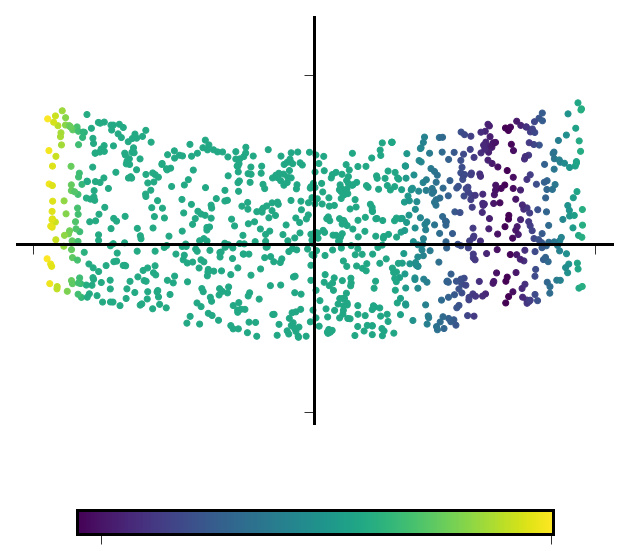

In [28]:
# Supplementary Figure 3
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[0]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [-.0525, -.0494])
CBI.ax.set_xticklabels(['',''])

xlab = [-.5,0,.5]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.3, 0, .3]
plt.yticks(ylab, xlabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

plt.savefig('ToyExampleEvals1.svg', dpi=200, transparent=True)
plt.show()

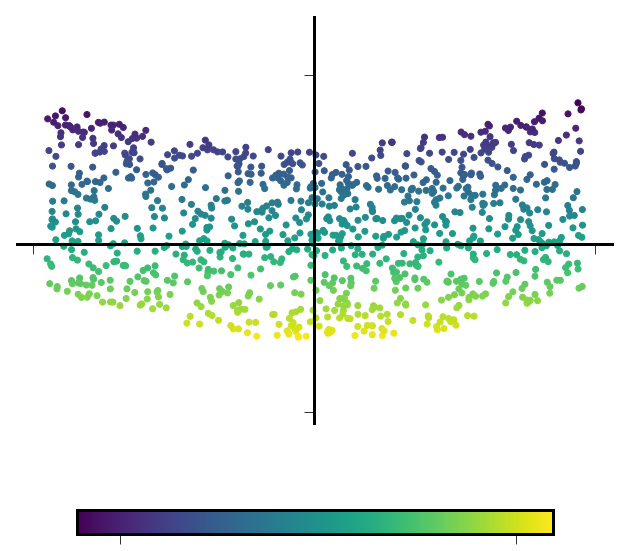

In [29]:
# Supplementary Figure 3
fig = plt.figure(figsize=(16/3*2,16/3*2))
ax = fig.add_subplot(111)
sc = ax.scatter(np.asarray(yk[:,0]), np.asarray(yk[:,1]), c=np.asarray(omegas[1]))
CBI = plt.colorbar(sc, orientation='horizontal', shrink=.8, ticks = [-.9993, -0.9984])
CBI.ax.set_xticklabels(['',''])

xlab = [-.5,0,.5]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.3, 0, .3]
plt.yticks(ylab, xlabels)
#plt.ylim([-.4, .55])
#plt.xlim([-.4, .4])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.axis('equal')

plt.savefig('ToyExampleEvals2.svg', dpi=200, transparent=True)
plt.show()

In [30]:
print('Reconstruction error on initial conditions: %.2E' % np.mean(np.square(Xk - xk_recon)))
print('1-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:]))))
print('2-step prediction error on initial conditions: %.2E' % np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:]))))

Reconstruction error on initial conditions: 1.03E-07
1-step prediction error on initial conditions: 9.48E-08
2-step prediction error on initial conditions: 9.28E-08


In [31]:
print('Relative reconstruction error on initial conditions: %.2E' % (np.mean(np.square(Xk - xk_recon))/np.mean(np.square(Xk))))
print('Relative 1-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus1 - np.squeeze(X_stacked[1,:,:])))/np.mean(np.square(np.squeeze(X_stacked[1,:,:])))))
print('Relative 2-step prediction error on initial conditions: %.2E' % (np.mean(np.square(xkplus2 - np.squeeze(X_stacked[2,:,:])))/np.mean(np.square(np.squeeze(X_stacked[2,:,:])))))

Relative reconstruction error on initial conditions: 1.22E-06
Relative 1-step prediction error on initial conditions: 1.16E-06
Relative 2-step prediction error on initial conditions: 1.16E-06


In [32]:
data = Xk.copy()

In [33]:
# For other plots, it's helpful to consider a full grid of input data
# Create a mesh grid and reshape it
xvals = np.linspace(np.min(data[:,0]),np.max(data[:,0]),400)
yvals = np.linspace(np.min(data[:,1]),np.max(data[:,1]),400)
X, Y = np.meshgrid(xvals, yvals)

grid = np.zeros((160000,2))
grid[:,0] = np.reshape(X, (160000,))
grid[:,1] = np.reshape(Y, (160000,))
print(grid.shape)

(160000, 2)


In [34]:
# Apply the network to the whole grid
grid_yk, grid_ykplus1, grid_ykplus2, grid_ykplus3, grid_xk_recon, grid_xkplus1, grid_xkplus2, grid_xkplus3 = n.ApplyKoopmanNetOmegas(grid, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

In [35]:
grid_reshaped0 = grid_yk[:,0].reshape(400,400)
grid_reshaped1 = grid_yk[:,1].reshape(400,400)

In [36]:
# Nice to draw a black outline
outline_x1 = np.asarray([-0.5, -0.5, 0.5])
outline_y1 = np.asarray([-0.5, 0.5, 0.5])
outline_x2 = np.asarray([-0.5, 0.5, 0.5])
outline_y2 = np.asarray([-0.5, -0.5, 0.5])

In [37]:
# calculate range of eigenfunction value in order to make colormap good and choose good levels to plot
print("1st eigenfunction ranges from %.4f to %.4f" % (np.min(grid_reshaped0), np.max(grid_reshaped0)))
grid_reshaped0_max = np.max(np.abs(grid_reshaped0))

1st eigenfunction ranges from -0.4749 to 0.4789


[-0.4 -0.2  0.   0.2  0.4]


<Figure size 432x288 with 0 Axes>

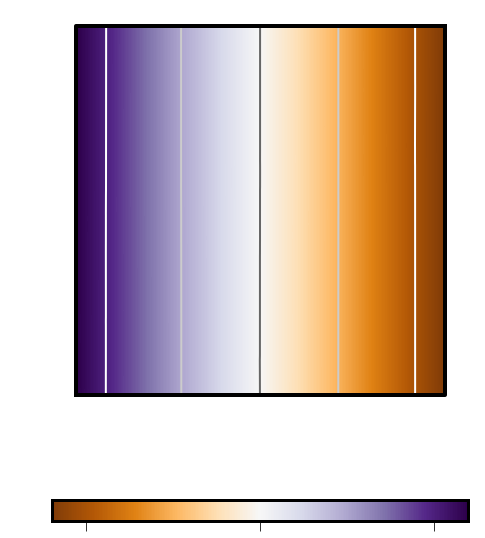

In [38]:
# Supplementary Figure 2
n.EigenfunctionPlot('PuOr',grid_reshaped0, outline_x1, outline_y1, outline_x2, 
                    outline_y2, X, Y, filename='ToyExampleEigenfunction1.png',
                   levels=np.arange(-.4,.6,.2), cbTicks=[-.4,0,.4],
                   climits=[-grid_reshaped0_max, grid_reshaped0_max])

In [39]:
print("2nd eigenfunction ranges from %.4f to %.4f" % (np.min(grid_reshaped1), np.max(grid_reshaped1)))
grid_reshaped1_max = np.max(np.abs(grid_reshaped1))

2nd eigenfunction ranges from -0.1696 to 0.2601


[-0.2 -0.1  0.   0.1  0.2]


<Figure size 432x288 with 0 Axes>

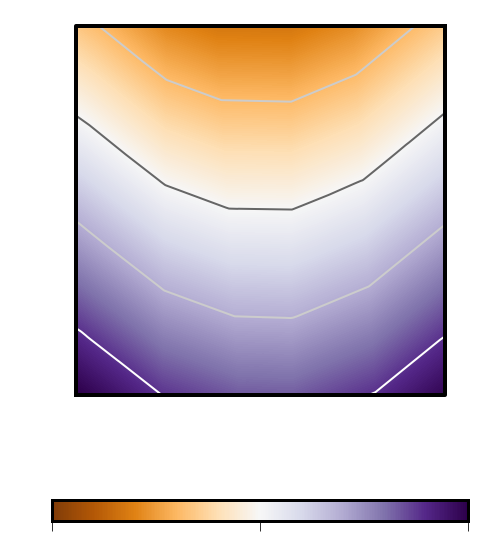

In [40]:
# Supplementary Figure 2
n.EigenfunctionPlot('PuOr',grid_reshaped1, outline_x1, outline_y1, outline_x2,
                    outline_y2, X, Y, filename='ToyExampleEigenfunction2.png',
                   levels=np.arange(-.2,.3,.1), cbTicks=[-.26,0,.26],
                   climits=[-grid_reshaped1_max, grid_reshaped1_max])

In [41]:
from sklearn import linear_model

In [42]:
# Ax = y, x in [num_ex, 2], y in [num_ex, 2], A is [num_ex, num_ex] 
print("Do linear regression to see how results compare to analytic option we know works.")
num_ex = grid.shape[0]
grid_aug = np.zeros((num_ex,6))
grid_aug[:,0] = np.ones((num_ex,))
grid_aug[:,1:3] = grid
grid_aug[:,3] = np.square(grid[:,0])
grid_aug[:,4] = np.square(grid[:,1])
grid_aug[:,5] = np.multiply(grid[:,0],grid[:,1])
coeff = np.linalg.lstsq(grid_aug, grid_yk)
print(coeff)

Do linear regression to see how results compare to analytic option we know works.
(matrix([[-9.44619823e-04,  6.72620120e-04],
        [-9.48769725e-01, -2.68783228e-03],
        [ 5.20966024e-05, -3.40873045e-01],
        [ 1.04102793e-02,  3.65167915e-01],
        [-8.50750436e-06,  6.70097319e-04],
        [-4.01731093e-04,  1.93034905e-02]]), matrix([[0.71802764, 0.36076437]]), 6, array([402.78103098, 115.52753251, 115.36312364,  33.31903796,
        29.80944601,  29.58719677]))


/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


In [43]:
print("Do linear regression with Lasso penalty to zero out most coefficients, making it easier to interpret")
clf = linear_model.Lasso(alpha=0.0005)
clf.fit(grid_aug, grid_yk)
print(clf.coef_)
print(clf.coef_[1,2]/clf.coef_[1,3])
rescaledb = clf.coef_[1,3]/(clf.coef_[0,1]**2)
print("compare scaling")
print(clf.coef_[1,2]/rescaledb)

Do linear regression with Lasso penalty to zero out most coefficients, making it easier to interpret
[[ 0.         -0.94275411  0.          0.         -0.         -0.        ]
 [ 0.         -0.         -0.33487502  0.27481503  0.          0.        ]]
-1.2185469827844944
compare scaling
-1.0830266588370043


In [44]:
# Load some nice evenly spaced trajectories that are good for plotting
trajs = np.loadtxt('DiscreteSpectrumExampleTrajs.csv', delimiter=',')

trajs  = trajs.reshape((trajs.shape[0],int(trajs.shape[1]/2), 2))

In [45]:
from matplotlib import cm

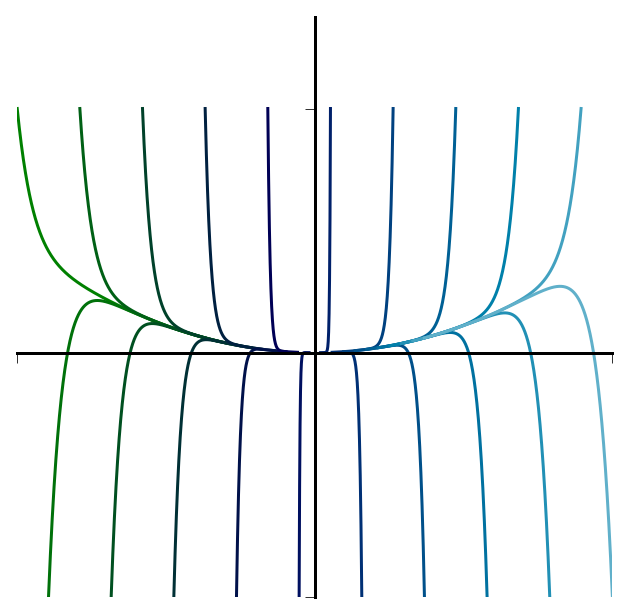

In [46]:
# We plot some nice trajectories from this system
# Left side of Figure 3
# create a special color map (version of ocean color map)
start = 0.0
stop = 1.0
number_of_lines= 25 
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [ cm.ocean(x) for x in cm_subsection ]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16/3*2)
fig.set_figheight(16/3*2)

for j in np.arange(trajs.shape[0]):
    temp = trajs[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], color=colors[j])
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.4, 0, .4]
plt.yticks(ylab, xlabels)
plt.ylim([-.4, .55])
plt.xlim([-.4, .4])
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.savefig('ToyExample.svg', dpi=200, transparent=True)

In [47]:
trajs_yk = np.zeros(trajs.shape)
trajs_recon = np.zeros(trajs.shape)
trajs_pred = np.zeros(trajs.shape)
trajs_lambdas = np.zeros(trajs.shape)

print('Eigenvalues for each traj. Note: about constant')
for j in np.arange(trajs.shape[0]):
    traj = np.squeeze(trajs[j,:,:])
    # apply the network to each trajectory
    traj_yk, traj_ykplus1, traj_ykplus2, traj_ykplus3, traj_xk_recon, traj_xkplus1, traj_xkplus2, traj_xkplus3 = n.ApplyKoopmanNetOmegas(traj, W, b, params['delta_t'], params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

    trajs_yk[j,:,:] = traj_yk.copy()
    trajs_recon[j,:,:] = traj_xk_recon.copy()
    trajs_pred[j,:,:] = traj_xkplus1.copy()
    
    # apply the auxiliary network to each one
    continuous_evals = n.omega_net_apply(traj_yk, W, b, params['num_real'], params['num_complex_pairs'], params['num_omega_weights'])

    # what's the average eigenvalue for this trajectory?
    # (note that for this system, we expect this to be constant along trajectories)
    # note that this is the discrete case: exp(lambda * deltat) if lambda is the eigenvalue in the continuous case
    mean_discrete_evals = np.zeros((len(continuous_evals),))
    for k in np.arange(trajs.shape[2]):
        mean_discrete_evals[k] = np.exp(np.mean(continuous_evals[k], axis=0)*params['delta_t'])
    print(mean_discrete_evals)
    
    # calculate eval^k for k = 0, 1, ....
    # should match if really have linear system    
    for k in np.arange(trajs.shape[1]):
        for l in np.arange(trajs.shape[2]):
            trajs_lambdas[j,k,l] = np.power(mean_discrete_evals[l],k)


Eigenvalues for each traj. Note: about constant
[0.99896872 0.98022315]
[0.99897257 0.98022249]
[0.99897687 0.98022321]
[0.9989806  0.98022254]
[0.99898358 0.98022326]
[0.99898556 0.98022259]
[0.99898613 0.98022332]
[0.99898617 0.98022263]
[0.9989862  0.98022329]
[0.99898624 0.98022258]
[0.99898627 0.98022328]
[0.99898631 0.98022262]
[0.99898634 0.98022335]
[0.99898638 0.98022266]
[0.99898642 0.98022331]
[0.99898645 0.98022259]
[0.99898649 0.98022323]
[0.99898653 0.98022254]
[0.99898656 0.98022317]
[0.9989866  0.98022247]


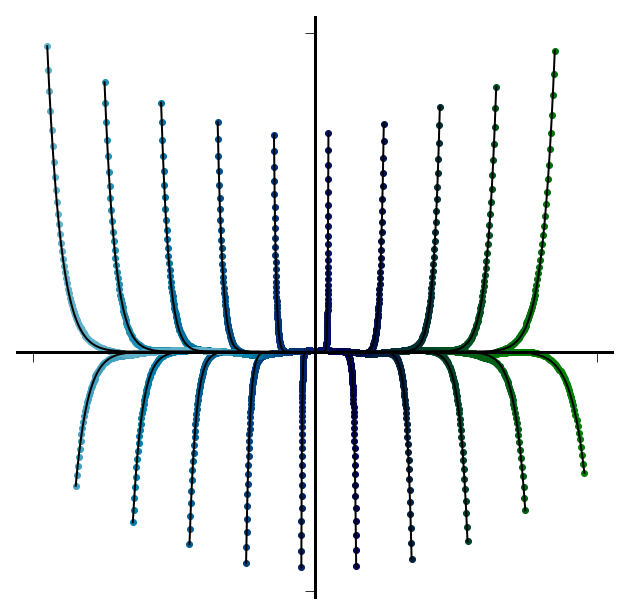

In [48]:
# Right side of Figure 3
# to check if really linear, 
# compare normalized eval^k (k = 0, 1, ...) to the y-coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16/3*2)
fig.set_figheight(16/3*2)

subset = np.arange(0,trajs.shape[1],4)

for j in np.arange(trajs.shape[0]):
    scale0 = trajs_yk[j,0,0]
    scale1 = trajs_yk[j,0,1]
    plt.plot(np.array(trajs_lambdas[j,:,0]*scale0), np.array(trajs_lambdas[j,:,1]*scale1), 'k', linewidth=2)
    ax.scatter(np.array(trajs_yk[j,subset,0]),np.array(trajs_yk[j,subset,1]), color=colors[j])

    
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.15, 0, .2]
plt.yticks(ylab, xlabels)
#plt.ylim([-.4, .55])
#plt.xlim([-.4, .4])


plt.savefig('ToyExampleLinear.svg', dpi=200, transparent=True)


([<matplotlib.axis.YTick at 0x11e4e5da0>,
 <a list of 0 Text yticklabel objects>)

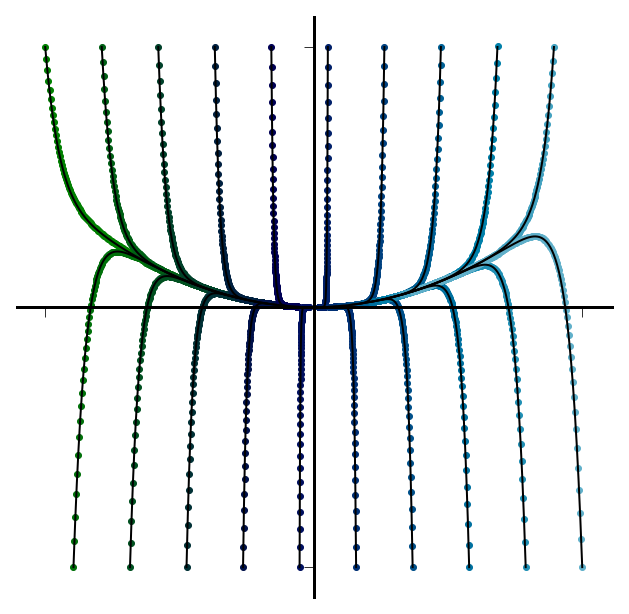

In [49]:
# plot reconstruction error
fig = plt.figure(figsize=(16/3*2, 16/3*2))
ax = fig.add_subplot(111)
subset = np.arange(0,trajs.shape[1],4)

for j in np.arange(trajs.shape[0]):
    temp = trajs[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], 'k', linewidth=2)
    temp2 = trajs_recon[j,:,:].copy()
    plt.scatter(temp2[subset,0],temp2[subset,1],color=colors[j])
    
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.4, 0, .4]
plt.yticks(ylab, xlabels)


#plt.savefig('ToyExampleRecon.png', dpi=200, transparent=True)

([<matplotlib.axis.YTick at 0x1208f3ef0>,
 <a list of 0 Text yticklabel objects>)

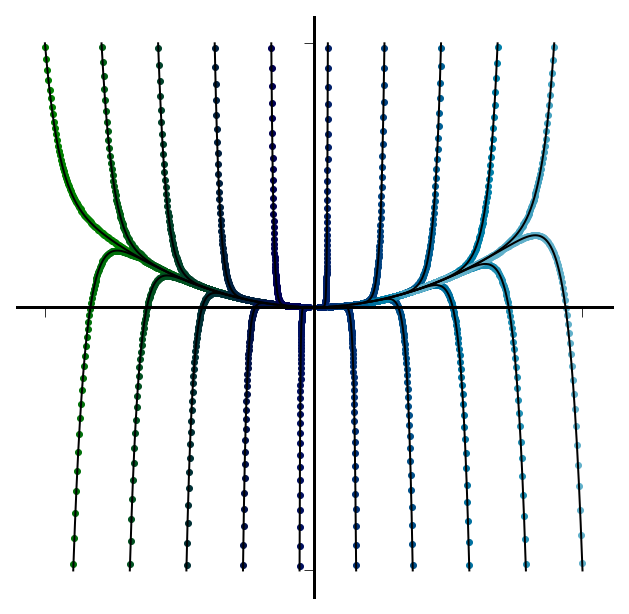

In [50]:
# plot 1-step prediction error
fig = plt.figure(figsize=(16/3*2, 16/3*2))
ax = fig.add_subplot(111)
subset = np.arange(0,trajs.shape[1],4)

for j in np.arange(trajs.shape[0]):
    temp = trajs[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], 'k', linewidth=2)
    temp2 = trajs_pred[j,:,:].copy()
    plt.scatter(temp2[subset,0],temp2[subset,1],color=colors[j])
    
#plt.axis('equal')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.4, 0, .4]
plt.yticks(ylab, xlabels)


In [51]:
# now apply network to these trajectories again, but this time for many steps
# this time, only network initial condition of each trajectory.
trajs_long_pred = np.zeros(trajs.shape)

num_steps = trajs.shape[1]-1

for j in np.arange(trajs.shape[0]):
    ic = np.squeeze(trajs[j,0,:])
    trajs_long_pred[j,0,:] = ic
    trajs_long_pred[j,1:,:] = n.PredictKoopmanNetOmegas(ic, W, b, deltat, num_steps, params['num_real'], params['num_complex_pairs'], 
                                                        params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

trajectory 0: worst rel. error 0.019
trajectory 1: worst rel. error 0.019
trajectory 2: worst rel. error 0.019
trajectory 3: worst rel. error 0.017
trajectory 4: worst rel. error 0.044
trajectory 5: worst rel. error 0.043
trajectory 6: worst rel. error 0.043
trajectory 7: worst rel. error 0.047
trajectory 8: worst rel. error 0.110
	first ind with error > 10p: 929 of 1001
trajectory 9: worst rel. error 0.354
	first ind with error > 10p: 157 of 1001
trajectory 10: worst rel. error 0.314
	first ind with error > 10p: 194 of 1001
trajectory 11: worst rel. error 0.070
trajectory 12: worst rel. error 0.085
trajectory 13: worst rel. error 0.087
trajectory 14: worst rel. error 0.087
trajectory 15: worst rel. error 0.087
trajectory 16: worst rel. error 0.046
trajectory 17: worst rel. error 0.019
trajectory 18: worst rel. error 0.019
trajectory 19: worst rel. error 0.019


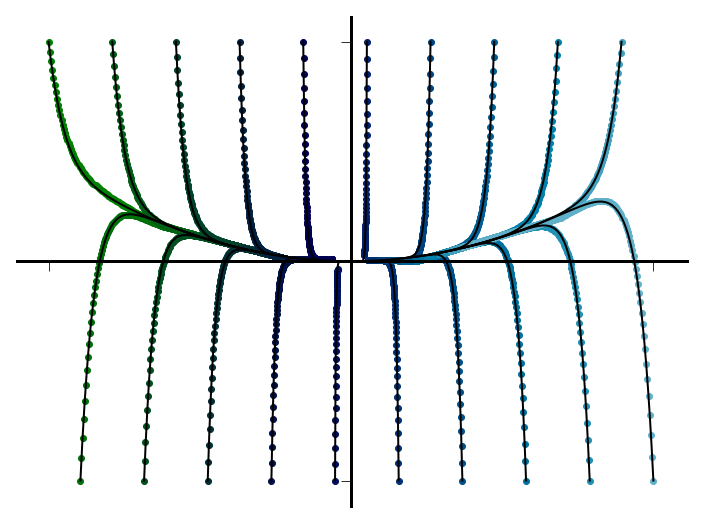

In [52]:
# Supplementary Figure 1b
# plot long-term prediction:
# if only give network initial condition, then have network predict many steps, how long is it accurate?

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)

for j in np.arange(trajs.shape[0]):
    temp = trajs[j,:,:].copy()
    plt.plot(temp[:,0],temp[:,1], 'k', linewidth=2)
    temp2 = trajs_long_pred[j,:,:].copy()
    
    diffs = np.linalg.norm(temp - temp2,ord=2,axis=1)

    normalize = np.linalg.norm(temp,ord=2,axis=1)
    relerr = diffs/normalize
    print("trajectory %d: worst rel. error %.3f" % (j, np.max(relerr)))
    indBigErr = np.nonzero(relerr > .1) # 10% error 
    if len(indBigErr[0]) > 0:
        print("\tfirst ind with error > 10p: %d of %d"  % (indBigErr[0][0], trajs.shape[1]))
        indEnd = indBigErr[0][0]
    else:
        indEnd = trajs.shape[1]

    subset = np.arange(0,indEnd,4)
    plt.scatter(temp2[subset,0],temp2[subset,1],color=colors[j])
    
xlab = [-.4,0,.4]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-.4, 0, .4]
plt.yticks(ylab, xlabels)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

plt.savefig('ToyExampleLongPrediction.svg', dpi=200, transparent=True)

In [53]:
# shape: num_examples, num_steps, n
# send initial conditions through network again, but predict many steps (50)
print('We now predict the initial conditions %d steps forward' % max_shifts_to_stack)
long_pred_Xk = n.PredictKoopmanNetOmegas(Xk, W, b, deltat, max_shifts_to_stack, params['num_real'], params['num_complex_pairs'], params['num_encoder_weights'], params['num_omega_weights'], params['num_decoder_weights'])

We now predict the initial conditions 50 steps forward


In [54]:
# how does prediction error change with the number of prediction steps?
# we expect it to accumulate error, but hopefully not too fast
long_pred_error = np.zeros((max_shifts_to_stack, ))
for j in np.arange(max_shifts_to_stack):
    long_pred_error[j] = np.mean(np.mean(np.square(long_pred_Xk[:,j,:] - X_stacked[j+1,:,:]), axis=0)) 

In [55]:
# so we can put ticks in good places
print('log10 error ranges from %.2f to %.2f' % (min(np.log10(long_pred_error)), max(np.log10(long_pred_error))))

log10 error ranges from -7.03 to -5.76


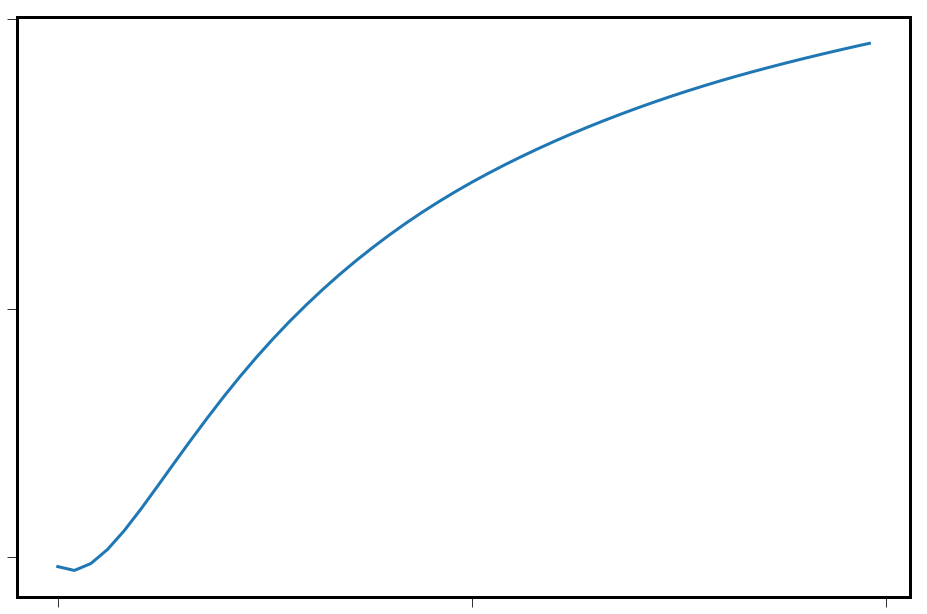

In [56]:
# Supplementary Figure 1a
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figwidth(16)
fig.set_figheight(16/3*2)

plt.plot(np.arange(max_shifts_to_stack), np.log10(long_pred_error), linewidth=3)

xlab = [0,max_shifts_to_stack/2, max_shifts_to_stack]
xlabels = ''
plt.xticks(xlab,xlabels)
ylab = [-5.7,-6.4,-7.0]
ylabels = ''
plt.yticks(ylab,ylabels)
fig.savefig('ToyExamplePredOverSteps.svg', dpi=200, transparent=True)

In [57]:
# moved this to the bottom because it's so slow
loss1_train, loss2_train, loss3_train, loss_Linf_train, loss_train, regularized_loss_train, total_num_traj = n.loss_training(params, max_shifts_to_stack, W, b)
print("# training traj: %d (goes in Table 2)" % total_num_traj)
print("Note: accidentally reported in paper that we used more data than we did.")
print("See DiscreteSpectrumExample.m: used 5000*.7 = 3500 per file, not 5000")

file 1 has 3500 trajectories
# training traj: 3500 (goes in Table 2)
Note: accidentally reported in paper that we used more data than we did.
See DiscreteSpectrumExample.m: used 5000*.7 = 3500 per file, not 5000


In [58]:
print('Reconstruction loss (on train set): %.4E' % loss1_train)
print('Prediction loss (on train set): %.4E' % loss2_train)
print('Linearity loss (on train set): %.4E' % loss3_train)
print('L_inf loss (on train set): %.4E' % loss_Linf_train)
print('Pre-regularization loss (on train set): %.4E (goes in Table 1)' % loss_train)
print('Total regularized loss (on train set): %.4E' % regularized_loss_train)

Reconstruction loss (on train set): 9.2434E-09
Prediction loss (on train set): 4.3168E-08
Linearity loss (on train set): 8.6508E-08
L_inf loss (on train set): 5.6665E-10
Pre-regularization loss (on train set): 1.3949E-07 (goes in Table 1)
Total regularized loss (on train set): 1.3949E-07


# Test error

DO NOT CALCULATE UNTIL READY TO REPORT FINAL RESULTS

In [59]:
## We decided to report this example in the paper, so now we can calcuate test errror
#loss1_test, loss2_test, loss3_test, loss_Linf_test, loss_test, regularized_loss_test = n.loss_test(params, max_shifts_to_stack, W, b)
#print("Note: accidentally reported in paper that we used more data than we did.")
#print("See DiscreteSpectrumExample.m: used 5000*.1 = 500 for testing, not 5000")

test file has 500 trajectories
Note: accidentally reported in paper that we used more data than we did.
See DiscreteSpectrumExample.m: used 5000*.1 = 500 for testing, not 5000


In [60]:
#print('Reconstruction loss (on test set): %.4E' % loss1_test)
#print('Prediction loss (on test set): %.4E' % loss2_test)
#print('Linearity loss (on test set): %.4E' % loss3_test)
#print('L_inf loss (on test set): %.4E' % loss_Linf_test)
#print('Pre-regularization loss (on test set): %.4E (goes in Table 1)' % loss_test)
#print('Total regularized loss (on test set): %.4E' % regularized_loss_test)

Reconstruction loss (on test set): 9.2567E-09
Prediction loss (on test set): 4.6744E-08
Linearity loss (on test set): 9.5893E-08
L_inf loss (on test set): 3.4969E-10
Pre-regularization loss (on test set): 1.5224E-07 (goes in Table 1)
Total regularized loss (on test set): 1.5224E-07


In [61]:
#print("Could be that error would be higher on larger test set, so try larger one.")
#print("Check test error on larger test set:")
#loss1_testextra, loss2_testextra, loss3_testextra, loss_Linf_testextra, loss_testextra, regularized_loss_testextra = n.loss_test(params, max_shifts_to_stack, W, b, suffix='testextra')
#print('Reconstruction loss (on larger test set): %.4E' % loss1_testextra)
#print('Prediction loss (on larger test set): %.4E' % loss2_testextra)
#print('Linearity loss (on larger test set): %.4E' % loss3_testextra)
#print('L_inf loss (on larger test set): %.4E' % loss_Linf_testextra)
#print('Pre-regularization loss (on larger test set): %.4E (compare to numbers in Table 1)' % loss_testextra)
#print('Total regularized loss (on larger test set): %.4E' % regularized_loss_testextra)

Could be that error would be higher on larger test set, so try larger one.
Check test error on larger test set:
test file has 5000 trajectories
Reconstruction loss (on larger test set): 1.0481E-08
Prediction loss (on larger test set): 4.5944E-08
Linearity loss (on larger test set): 9.2697E-08
L_inf loss (on larger test set): 1.0260E-09
Pre-regularization loss (on larger test set): 1.5015E-07 (compare to numbers in Table 1)
Total regularized loss (on larger test set): 1.5015E-07


In [62]:
#print("Good news: error even lower on larger test set!")

Good news: error even lower on larger test set!
